# 🧠 Parallelization Pattern

## **Concept**
Parallelization enables **concurrent execution** of independent sub-tasks (LLM calls, tool invocations, or sub-agents) to **reduce latency** and **boost efficiency** in agent workflows.

---

## **Key Idea**
Identify workflow components that **don’t depend on each other’s outputs** and execute them **simultaneously** instead of sequentially.

**Example:**
Instead of processing Source A → then Source B → then combining,
run **Source A and Source B in parallel**, summarize both, then synthesize results sequentially.

---

## **Technical Mechanisms**
- Use **asynchronous execution**, **multi-threading**, or **multi-processing**.  
- **LangChain (LCEL):** parallel runnables via concurrent branches.  
- **LangGraph:** parallel node execution from a single state transition.  
- **Google ADK:** native multi-agent concurrency and scheduling.

---

## **Benefits**
- Minimizes total execution time.  
- Handles API/database latency efficiently.  
- Improves responsiveness and scalability in agent systems.

---

## **Typical Use Cases**
1. **Information Gathering:** Query multiple data sources simultaneously.  
2. **Data Analysis:** Run sentiment, keyword, and category extraction in parallel.  
3. **Multi-API Calls:** Fetch flights, hotels, and events concurrently.  
4. **Content Generation:** Create subject, body, and visuals simultaneously.  
5. **Validation:** Perform independent input checks in parallel.  
6. **Multi-Modal Processing:** Analyze text, image, and audio together.  
7. **A/B Testing:** Generate multiple variants concurrently.

---

## **Takeaway**
Parallelization is a **core optimization pattern** for **agentic design**, enabling faster, more efficient, and scalable AI systems by leveraging concurrent execution of independent tasks.



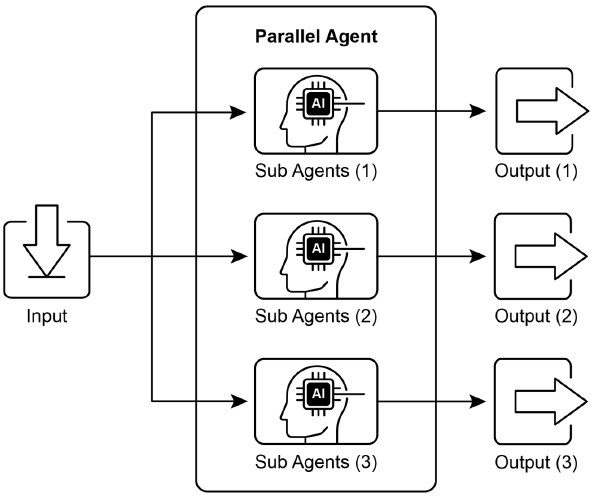

In [1]:
from typing import Annotated, TypedDict, Any
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import START, END, StateGraph, MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from langgraph.errors import InvalidUpdateError

from IPython.display import display, Image

import operator

In [2]:
load_dotenv()

True

### Very Note:
- `Node concurrency` and `merge semantics` depend on state annotations (Annotated fields) or aggregation operators like operator.add.

In [3]:
class GraphState(TypedDict):
    query: str
    messages: Annotated[list, add_messages]

In [4]:
# --- Step 2: Initialize the LLM ---
llm = ChatOpenAI(
    model="/gpfs/projects/bsc02/llm_models/huggingface_models/Qwen3-32B",
    openai_api_key="dummy",  # vLLM doesn't need a real key
    openai_api_base="http://localhost:8002/v1",  # Your forwarded port
    temperature=0.7,
    max_tokens=1000
)

In [5]:
# --- Step 3: Define nodes (subtasks) ---
def research_agent_a(state: GraphState):
    print("🔹 Agent A: Researching technical details...")
    response = llm.invoke([{"role": "user", "content": f"Summarize the technical side of: {state['query']}"}])
    return {"messages": [response]}

def research_agent_b(state: GraphState):
    print("🔹 Agent B: Researching business perspective...")
    response = llm.invoke([{"role": "user", "content": f"Summarize the business impact of: {state['query']}"}])
    return {"messages": [response]}

def synthesis_agent(state: GraphState):
    print("🔹 Synthesizing combined responses...")
    response = llm.invoke(state["messages"] + [{"role": "user", "content": "Combine the insights above into a concise summary."}])
    return {"messages": [response]}

In [6]:
# --- Step 4: Build the graph ---
graph = StateGraph(GraphState)

# Add nodes
graph.add_node("agent_a", research_agent_a)
graph.add_node("agent_b", research_agent_b)
graph.add_node("synthesis", synthesis_agent)

# --- Step 5: Define parallel and sequential edges ---
graph.add_edge(START, "agent_a")
graph.add_edge(START, "agent_b")

# Merge both agent outputs before synthesis
graph.add_edge("agent_a", "synthesis")
graph.add_edge("agent_b", "synthesis")
graph.add_edge("synthesis", END)

# --- Step 6: Compile and run ---
app = graph.compile()

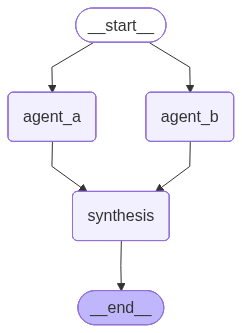

In [7]:
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
result = app.invoke({"query": "The future of AI agent frameworks like LangGraph and ADK"})

🔹 Agent A: Researching technical details...
🔹 Agent B: Researching business perspective...
🔹 Synthesizing combined responses...


In [9]:
print("\n✅ Final Combined Summary:\n")
print(result["messages"][-1].content)


✅ Final Combined Summary:

<think>
Okay, the user wants me to combine the previous insights into a concise summary. Let me start by recalling what the user provided. They had two parts: one about the technical aspects of LangGraph and ADK's future, and another about the business impact of these frameworks. The user then asked to combine these into a concise summary.

First, I need to ensure I cover both the technical and business angles. The technical part mentioned scalability, modular architectures, advanced reasoning, real-time capabilities, security, multi-agent systems, user-friendly interfaces, integration with emerging models, and community/ecosystem growth. The business part highlighted operational efficiency, cost reduction, democratization of AI, economic gains, challenges like integration and job displacement, and industry-specific impacts.

I should start by outlining the main points from each section and find a logical flow. Maybe start with how these frameworks are advan